In [1]:
#load aiida environment and connect to database
from aiida import load_profile
from aiida.orm import computers
profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [2]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData, ArrayData
from aiida.orm import (Group, load_group, load_node, load_code, groups,
                      WorkChainNode, QueryBuilder, CalcJobNode)
from aiida.engine import submit
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import (kkr_imp_sub_wc, kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc, combine_imps_wc,
                                 kkr_flex_wc)
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, VoronoiCalculation
import matplotlib.pyplot as plt
from aiida_kkr.tools.common_workfunctions import get_username
from masci_tools.io.common_functions import get_Ry2eV
import tarfile

In [3]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
from __future__ import unicode_literals
from builtins import object, str
from six.moves import range
from six.moves import input
from masci_tools.io.common_functions import open_general
from masci_tools.io.common_functions import search_string
import numpy as np
from masci_tools.io.common_functions import get_alat_from_bravais
from masci_tools.io.common_functions import vec_to_angles
from aiida.common.constants import elements as PeriodicTableElements
_atomic_numbers = {data['symbol']:num for num,
                data in PeriodicTableElements.items()}
load_stuc = load_node(234)
load_stuc

<StructureData: uuid: c1626804-5b71-450c-91c4-aa7197d85279 (pk: 234)>

In [4]:
node_16215 = load_node(16215)
node_16100 = load_node(16100)
# node_16215.outputs.
# node_16100.outputs.workflow_info.pk

In [ ]:
# imp_dos_group = load_group(72)

plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[2:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
    # highlight the contibution of the impurity (iatom=0)
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0, 
            )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

In [ ]:
# imp_dos_group = load_group(72)

plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[2:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
#     # highlight the contibution of the impurity (iatom=0)
#     plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
#              noshow=True, nofig=True, color='C'+str(i),
#              lw=3, iatom=0, 
#             )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

No handles with labels found to put in legend.


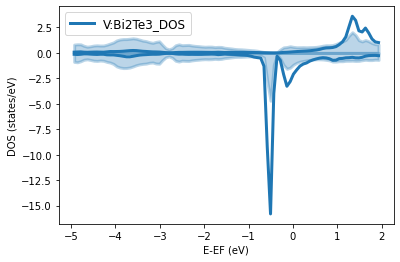

In [138]:
plt.figure()
for i, imp_dos in enumerate(imp_dos_group.nodes[3:4]):
    # plot the contribution of the total impurity cluster into the background
    # we scale this down by 0.5 to have copatible y-scales
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=None,
             noshow=True, nofig=True, color='C'+str(i),
             filled=True, alpha=0.3, yscale=0.5, lw=3
            )
    # highlight the contibution of the impurity (iatom=0)
    plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0, 
            )
plt.legend(loc=2, fontsize='large')
plt.title('')
plt.show()

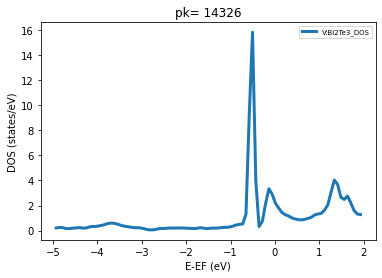

In [139]:
 plot_kkr(imp_dos, l_channels=False, strucplot=False, silent=True, label=imp_dos.label,
             noshow=True, nofig=True, color='C'+str(i),
             lw=3, iatom=0,all_atoms= False, sum_spins= True,)

In [140]:
#imp_kkr_wc = 10085
imp_out = load_node(11948)
# kkrimp_calc = imp_out.outputs.last_calc_output_parameters.get_incoming(KkrimpCalculation).all()
# imp_info = imp_out.outputs.workflow_info.get_incoming(link_label_filter='workflow_info').all()
# # print(imp_info[0].node)
# print(kkrimp_calc[0].node)
ldau_test = imp_out.outputs.workflow_info.get_dict()
# ldau_test

In [274]:
kkr = None
if kkr == None:
    print('ok')

ok


In [261]:
####### NOTE: If this csucessful then please add it into the 'tools_development' ipynb
## In this part the node has been collected to store in new group only considering the kkr_imp_wc node
group_wasmer = load_group(83)
# node_label
debug= False
wasmer_grp_list = list(group_wasmer.nodes)
group_label = 'imp_embedded_Au_by_wasmer'
try:
    new_grp = load_group(node_label)
    print('Group as named %s is already stored, so no need to create the group'%(node_label))
except:
    new_grp = Group(label=group_label)
    new_grp.store()
    print(' A new node created as named %s' %node_label)
new_grp_list = list(new_grp.nodes)
i=0
imp_wc_no = 0
for index in range(len(wasmer_grp_list)):
    node = wasmer_grp_list[index]
    if node.node_type.split('.')[-2]=='WorkChainNode':
        if (u'kkr_imp_wc' == node.process_label):
            imp_wc_no += 1
            if node in new_grp_list[:]:
                print('node {} is already exist'.format(node.pk))
            else:
                new_grp.add_nodes(node)
            if debug:
                print(node.process_label)
                print('pk: %7d'%node.pk)
                print(wasmer_grp_list[i])
                print(node.label)
                
                        
        

print(imp_wc_no)

Group as named imp_embedded_Au_by_wasmer is already stored, so no need to create the group
39


In [106]:
# This is for kkrimpcalc step-1
[['NSPIN', 2], ['HFIELD', [0.0, 0]], ['INS', 1], ['NCOLL', 1], ['SPINORBIT', 1], ['SCFSTEPS', 100], ['IMIX', 0], ['MIXFAC', 0.001], ['QBOUND', 0.008], ['TESTFLAG', ['tmatnew']], ['CALCORBITALMOMENT', 1]]
[['NSPIN', 2], ['HFIELD', [0.02, 5]], ['INS', 1], ['NCOLL', 1], ['SPINORBIT', 1], ['SCFSTEPS', 300], ['IMIX', 0], ['MIXFAC', 0.02], ['QBOUND', 0.05], ['TESTFLAG', ['tmatnew']], ['CALCORBITALMOMENT', 1]]
# This is for kkrimpcalc step-2
[['NSPIN', 2], ['HFIELD', [0.0, 0]], ['INS', 1], ['NCOLL', 1], ['SPINORBIT', 1], ['SCFSTEPS', 100], ['IMIX', 5], ['MIXFAC', 0.008], ['ITDBRY', 60], ['QBOUND', 1e-07], ['NSIMPLEMIXFIRST', 0], ['TESTFLAG', ['tmatnew']], ['CALCORBITALMOMENT', 1]]
[['NSPIN', 2], ['HFIELD', [0.0, 0]], ['INS', 1], ['NCOLL', 1], ['SPINORBIT', 1], ['SCFSTEPS', 300], ['IMIX', 5], ['MIXFAC', 0.05], ['ITDBRY', 20], ['QBOUND', 1e-07], ['NSIMPLEMIXFIRST', 0], ['TESTFLAG', ['tmatnew']], ['CALCORBITALMOMENT', 1]]

[['NSPIN', 2],
 ['HFIELD', [0.0, 0]],
 ['INS', 1],
 ['NCOLL', 1],
 ['SPINORBIT', 1],
 ['SCFSTEPS', 100],
 ['IMIX', 5],
 ['MIXFAC', 0.008],
 ['ITDBRY', 60],
 ['QBOUND', 1e-07],
 ['NSIMPLEMIXFIRST', 0],
 ['TESTFLAG', ['tmatnew']],
 ['CALCORBITALMOMENT', 1]]

In [426]:
## DOS group:
ilayer_3 = list(load_group(94).nodes)
ilayer_4 = list(load_group(93).nodes)
ilayer_3 = [i.pk for i in ilayer_3[:]]
ilayer_4 = [i.pk for i in ilayer_4[:]]
ilayer_3_4 = zip(ilayer_3, ilayer_4)
list(ilayer_3_4)


[(22896, 21270),
 (22907, 21312),
 (22910, 21316),
 (22913, 21321),
 (22916, 21325),
 (22919, 21330),
 (22922, 21335),
 (22925, 21341),
 (22928, 21345),
 (22933, 21350),
 (22938, 21354),
 (22942, 21359),
 (22947, 21362),
 (22953, 21368),
 (22956, 21373),
 (22962, 21377),
 (22966, 21382),
 (22971, 21386),
 (22975, 21391)]

In [439]:
node_16346 = load_node(23784)
node_16346.outputs.workflow_info.get_dict()['sub_workflows']

{'host_gf': {'pk': 23790, 'uuid': '96779c30-20b2-42dd-92ce-47ce6a3de15f'},
 'kkrimp_scf': {'pk': 23823, 'uuid': '7feebdb4-c22a-427b-b362-52a5ffa537f1'}}

In [457]:
group = load_group(74)
nodes = list(group.nodes)
node_0 = nodes[6]
kkrimp_cal = node_0.get_outgoing(node_class=kkr_imp_sub_wc).first().node.get_outgoing(node_class=KkrimpCalculation).first().node
host_parent = kkrimp_cal.inputs.host_Greenfunction_folder
host_structure, _ = VoronoiCalculation.find_parent_structure(host_parent)

In [496]:
group_94 = load_group(91)
group_94 = list(group_94.nodes)
group_94[1].pk

18853

In [518]:
node = load_node(234)
node.outputs.JijData.get_array('JijData')

array([], dtype=float64)

In [536]:
node = load_node(24510)
jij_data = node.outputs.JijData.get_array('JijData')
print(np.shape(jij_data))
print(type(jij_data))

jij_data[:]

(0,)
<class 'numpy.ndarray'>


array([], dtype=float64)

In [617]:
combine_kkr = load_node(24418)
]
print(imp1)
print(imp2)

22
23


In [616]:
import tarfile
# To find the impurity_info and retrieved file
kkr_imp_sub =load_node(24365)
impurity_info = kkr_imp_sub.inputs.impurity_info
print(type(impurity_info))
node = load_node(24461)
retrieved = node.outputs.retrieved
retrieved.list_object_names()

_FILENAME_TAR = 'output_all.tar.gz'

if _FILENAME_TAR in retrieved.list_object_names():
    # get path of tarfile
    with retrieved.open(_FILENAME_TAR) as tf:
        tfpath = tf.name
    # extract file from tarfile of retrieved to tempfolder
    with tarfile.open(tfpath) as tf:
        tar_filenames = [ifile.name for ifile in tf.getmembers()]
        filename = 'out_Jijmatrix'
        if filename in tar_filenames:
            tf.extract(filename, tfpath.replace(_FILENAME_TAR,'')) # extract to tempfolder

jijdata = np.loadtxt(tfpath.replace(_FILENAME_TAR,'')+'out_Jijmatrix')
## To debug-------------------------
print('jijdata : ',jijdata)
print('Shape jijdata : ',np.shape(jijdata))


impurity_info = impurity_info.get_dict()
pos = np.array(impurity_info['imp_cls'])
z = np.array(impurity_info['imp_cls'])[:,4]
print('impurity_info[imp_cls]',impurity_info['imp_cls'])
imp1= 23 # This value will be collected from the imp1_out_node. 
imp2= 22 # This value will be collected from the imp2_out_node
Vpos =  list(np.where(z==imp1)[0]) + list(np.where(z==imp2)[0])

print('Vpos : ', Vpos)

Ry2eV = get_Ry2eV()

# extract number of atoms
natom = int(np.sqrt(jijdata.shape[0]/3/3))

# reshape data
jij_reshape = jijdata.reshape(3, natom, natom, 3, 3) # iter, i, j, k, l (Jij_k,l matrix)
# print('Jij_reshape : ', jij_reshape)
print('Shape of Jij_reshape : ', np.shape(jij_reshape))

# now combine iterations to get full 3 by 3 Jij matrices for all atom pairs
jij_combined_iter = np.zeros((natom, natom, 3, 3))
for iatom in range(natom):
    for jatom in range(natom):
        for iiter in range(3):
            if iiter==0:
                # first iteration with theta, phi = 0, 0
                # take complete upper block from here since this calculation should be converged best
                # (rotated moments only one-shot calculations)
                jij_combined_iter[iatom, jatom, 0, 0] = jij_reshape[iiter, iatom, jatom, 0, 0]
                jij_combined_iter[iatom, jatom, 0, 1] = jij_reshape[iiter, iatom, jatom, 0, 1]
                jij_combined_iter[iatom, jatom, 1, 0] = jij_reshape[iiter, iatom, jatom, 1, 0]
                jij_combined_iter[iatom, jatom, 1, 1] = jij_reshape[iiter, iatom, jatom, 1, 1]
            elif iiter==1:
                # second iteraton with theta, phi = 90, 0
                jij_combined_iter[iatom, jatom, 1, 2] = jij_reshape[iiter, iatom, jatom, 1, 2]
                jij_combined_iter[iatom, jatom, 2, 1] = jij_reshape[iiter, iatom, jatom, 2, 1]
                jij_combined_iter[iatom, jatom, 2, 2] = jij_reshape[iiter, iatom, jatom, 2, 2]
            else:
                # from third iteration with theta, phi = 90, 90
                jij_combined_iter[iatom, jatom, 0, 2] = jij_reshape[iiter, iatom, jatom, 0, 2]
                jij_combined_iter[iatom, jatom, 2, 0] = jij_reshape[iiter, iatom, jatom, 2, 0]
                # add this value to z-z component and average
                jij_combined_iter[iatom, jatom, 2, 2] += jij_reshape[iiter, iatom, jatom, 2, 2]
                jij_combined_iter[iatom, jatom, 2, 2] *= 0.5

# finally convert to meV units (and sign change to have positive number indicate ferromagnetism and negative number antiferromagnetism)
jij_combined_iter *= -1.*Ry2eV*1000

jij_trace = (jij_combined_iter[:,:,0,0]+jij_combined_iter[:,:,1,1]+jij_combined_iter[:,:,2,2])/3
Dij_vec = np.array([(jij_combined_iter[:,:,1,2]-jij_combined_iter[:,:,2,1]), (jij_combined_iter[:,:,2,0]-jij_combined_iter[:,:,0,2]), (jij_combined_iter[:,:,0,1]-jij_combined_iter[:,:,1,0])])

plotdata = []

#return jij_combined_iter
out_txt = "Output Jij values between V impurities:\ni   j     Jij (meV)       Dij(meV)        D/J\n-----------------------------------------------\n"
print('natom : ', natom)
for iatom in range(natom):

    for jatom in range(natom):

        if iatom!=jatom and iatom in Vpos and jatom in Vpos:
            print('this is ok---------')
            J = jij_trace[iatom, jatom]
            Dx, Dy, Dz = Dij_vec[0, iatom , jatom], Dij_vec[1, iatom , jatom], Dij_vec[2, iatom , jatom]
            D = np.sqrt(Dx**2 + Dy**2 + Dz**2)
            out_txt += '%3i %3i %15.5e %15.5e %15.5e\n'%(iatom, jatom, J, D, D/J)
            rdiff = pos[jatom] - pos[iatom]
            print('[rdiff[0], rdiff[1], rdiff[2], J, D, Dx, Dy, Dz] : ',[rdiff[0], rdiff[1], rdiff[2], J, D, Dx, Dy, Dz])
            plotdata.append([rdiff[0], rdiff[1], rdiff[2], J, D, Dx, Dy, Dz])
## To debug-------------------------
print('This is the plotdata : ', plotdata)
plotdata = np.array(plotdata)

a = ArrayData()
a.set_array('JijData', plotdata)

#return {'Jijdata': a, 'info': Dict(dict={'text': out_txt})}

<class 'aiida.orm.nodes.data.dict.Dict'>
jijdata :  [[ 9.71891464e-03 -4.30386615e-06 -1.87604979e-05]
 [-4.30386615e-06  9.71153387e-03  6.77291724e-07]
 [-1.87604979e-05  6.77291724e-07 -7.39626474e-04]
 ...
 [ 3.05283967e-07 -3.32337413e-10  1.34759307e-10]
 [-3.32337413e-10  3.61499885e-07 -1.24339119e-09]
 [ 1.34759307e-10 -1.24339119e-09  3.02323149e-07]]
Shape jijdata :  (6084, 3)
impurity_info[imp_cls] [[0.0, 0.0, 0.0, 4.0, 22.0, 0.0], [0.0, -0.24162968646393, 0.09703685354645, 6.0, 1.0, 0.26038635971735], [-0.20925744678623, -0.12081484323197, -0.09703685354645, 9.0, 1.0, 0.26038635971735], [0.20925744678623, -0.12081484323197, -0.09703685354645, 9.0, 1.0, 0.26038635971735], [-0.20925744678623, 0.12081484323198, 0.09703685354645, 6.0, 1.0, 0.26038635971736], [0.20925744678623, 0.12081484323198, 0.09703685354645, 6.0, 1.0, 0.26038635971736], [0.0, 0.24162968646394, -0.09703685354645, 9.0, 1.0, 0.26038635971736], [-0.20925744678623, -0.12081484323197, 0.15914043981621, 3.0, 52.0

In [569]:
a.get_array('JijData')

array([], dtype=float64)

In [606]:
# Create a Numpy array from a list
arr = np.array([11, 12, 13, 14])
high_values = ['High', 'High', 'High', 'High']
low_values = ['Low', 'Low', 'Low', 'Low']
# numpy where() with condition argument
result = np.where(arr > 12,
                  ['High1', 'High2', 'High3', 'High4'],
                  ['Low1', 'Low2', 'Low3', 'Low4'])
print(result)
type(result)

['Low1' 'Low2' 'High3' 'High4']


numpy.ndarray

In [642]:
ll = list(np.where( z == 22 )[0]) + list(np.where( z == 23 )[0])

In [643]:
z

array([22.,  1.,  1.,  1.,  1.,  1.,  1., 52., 52., 52.,  1.,  1., 52.,
       52., 52., 23.,  1.,  1.,  1.,  1., 52., 52.,  1.,  1., 52., 52.])

In [644]:
ll

[0, 15]

In [8]:
calcjob_node = load_node(24650)
calcjob_node.get_remote_workdir()

'/rwthfs/rz/cluster/work/jara0191/ck142666/aiida/computers/claix18_init/8c/bb/abd5-8288-469b-a045-9569e8a14876'